In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5, alpha=0.25)
    fig.axes[i].axvline(0, color='w', linewidth=3.5, alpha=0.25)
    fig.axes[i].set_xlim(-3.5,3.5)
    fig.axes[i].set_ylim(-3.5,3.5)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])

In [4]:
# Initialize input space first
vv, hh = np.mgrid[-4:4:101j, -4:4:101j]
h_ = hh.shape[0]
x_in = np.stack((hh.ravel(), vv.ravel()), axis=0)

# Parameters
batches = x_in.shape[1]
t_steps = 1 # not including t=0.
algs = 2
layers = 1 # not including l=0
alpha = .5

b = int(batches/2 + 11)

# Target function
T = np.random.randn(2,2)/np.sqrt(2)
T = np.array([[0.1, -1], [1, -0.2]])
y = np.dot(T, x_in[:, b])

# Initialize the output space
y_coord = np.zeros((algs, t_steps+1, layers+1), dtype=object)
L = np.zeros((algs, t_steps+1, layers+1), dtype=object)
Lval = np.zeros((algs, t_steps+1, layers+1), dtype=object)
for k in range(algs):
    for t in range(t_steps+1):
        y_coord[k, t, -1] = np.stack((hh.ravel(), vv.ravel()), axis=0)

# Loss function on last layer
for k in range(algs):
    for t in range(t_steps+1):
        L[k, t, -1] = 0.5*((y_coord[k, t, -1][0] - y[0])**2 + (y_coord[k, t, -1][1] - y[1])**2)

In [5]:
# Forward weights
W = np.zeros((algs, t_steps+1, layers+1), dtype=object)
dW = np.zeros((algs, t_steps+1, layers+1), dtype=object)

# Initialize forward weights
for k in range(algs):
    for l in range(1, layers+1):
        W[k, 0, l] = np.eye(2)

# Activations
x = np.zeros((algs, t_steps+1, layers+1), dtype=object)
# Error / targets
dx = np.zeros((algs, t_steps+1, layers+1), dtype=object)

# Initialize activations
for k in range(algs):
    for t in range(t_steps+1):
        x[k, t, 0] = x_in[:, b]

In [6]:
for t in range(t_steps+1):
    for k in range(algs):
        # Forward pass:
        for l in range(1, layers+1):
            x[k, t, l] = np.dot(W[k, t, l], x[k, t, l-1])
            Lval[k, t, l] = 0.5*((x[k, t, l][0] - y[0])**2 + (x[k, t, l][1] - y[1])**2)

        # Backward pass:
        dx[k, t, -1] = x[k, t, -1] - y
        for l in range(layers-1, 0, -1):
            if k == 0:
                dx[k, t, l] = np.dot(W[k, t, l+1].T, dx[k, t, l+1])
                y_coord[k, t, l] = np.dot(W[k, t, l+1].T, y_coord[k, t, l+1])
                L[k, t, l] = 0.5*((y_coord[k, t, l][0] - y[0])**2 + (y_coord[k, t, l][1] - y[1])**2)
            elif k == 1:
                dx[k, t, l] = x[k, t, l] + np.dot(np.linalg.pinv(W[k, t, l+1]), dx[k, t, l+1]) - np.dot(np.linalg.pinv(W[k, t, l+1]), x[k, t, l+1])
                y_coord[k, t, l] = x[k, t, l] + np.dot(np.linalg.pinv(W[k, t, l+1]), dx[k, t, l+1]) - np.dot(np.linalg.pinv(W[k, t, l+1]), y_coord[k, t, l+1])
                L[k, t, l] = 0.5*((y_coord[k, t, l][0] - y[0])**2 + (y_coord[k, t, l][1] - y[1])**2)

        for l in range(1, layers+1):
            # test backprop vs pinv here
            dW[k, t, l] = -alpha*np.outer(dx[k, t, l], x[k, t, l-1])            
            if t != t_steps:
                W[k, t+1, l] = W[k, t, l] + dW[k, t, l]

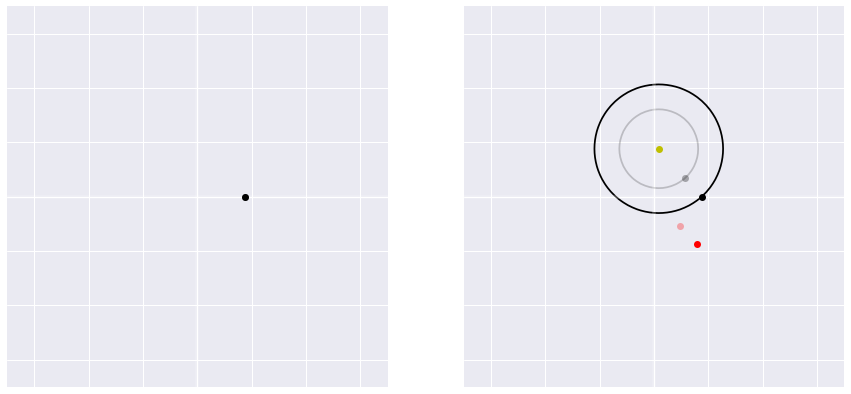

In [7]:
# Plot
fig, ax = plt.subplots(1, layers+1, figsize=(15,15))
for l in range(layers+1):
    square_axes(l)
    
k = 0

t = 0
#b = 20
for l in range(layers+1):
    ax[l].plot(x[k, t, l][0], x[k, t, l][1], 'ko')
for l in range(1, layers+1):
    ax[l].plot(dx[k, t, l][0], dx[k, t, l][1], 'ro')
    ax[l].contour(y_coord[k, t, l][0].reshape([h_, h_]), y_coord[k, t, l][1].reshape([h_, h_]), L[k, t, -1].reshape([h_, h_]), [Lval[k, t, -1]], alpha=1, colors='k')

for t in range(1, t_steps+1):
    for l in range(layers+1):
        ax[l].plot(x[k, t, l][0], x[k, t, l][1],'ko', alpha=0.3)
    for l in range(1, layers+1):
        ax[l].plot(dx[k, t, l][0], dx[k, t, l][1], 'ro', alpha=0.3)
        ax[l].contour(y_coord[k, t, l][0].reshape([h_, h_]), y_coord[k, t, l][1].reshape([h_, h_]), L[k, t, -1].reshape([h_, h_]), [Lval[k, t, l]], alpha=0.2, colors='k')

ax[-1].plot(y[0], y[1], 'yo')

plt.show()

In [ ]:
y_coord[k, t, l][0, :].reshape([11, 11])

In [ ]:
y_coord[k, t, l][1, :].reshape([11, 11]).shape

In [ ]:
L[k, t, l, :].reshape([11, 11]).shape

In [ ]:
L[k, t, 2, :].reshape([11, 11])

In [ ]:
t